# Feelee Project


In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.graph_objects as go
from wordcloud import WordCloud
import networkx as nx

import xgboost as xgb
from xgboost import plot_importance
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## FUNCTIONS

### CLEANING AND DATA PREPARATION

#### CLEANING

In [2]:
def check_gender_birthday_discrepancy(data):
    # Group the data by user_id
    users = data.user_id.unique()

    # Initialize a list to store user IDs with discrepancies
    users_with_discrepancies = []

    # Iterate over each group
    for user_id in users:
        temp = data.loc[data.user_id == user_id]
        # Check if there are multiple unique values for gender or birthday
        if temp.gender.nunique() > 1 or temp.birthday.nunique() > 1:
            users_with_discrepancies.append(user_id)

    return users_with_discrepancies

def create_new_users(data, users):
    new_user_id = 10_000
    clean_users = data.loc[~data.user_id.isin(users)]
    disc_users = data.loc[data.user_id.isin(users)]

    total = [clean_users]

    for user in users:
        disc_user = disc_users.loc[disc_users.user_id == user]
        tmp = []
        for i, (_, g) in enumerate(disc_user.groupby(["gender","birthday"])):
            if i:
                g["user_id"] = new_user_id
                new_user_id = new_user_id + 1
            tmp.append(g)
        total.append(pd.concat(tmp))
    return pd.concat(total).reset_index(drop=True)

def cleaning():
    df = pd.read_excel("Garage2020_dataset.xlsx")
    df.loc[38043, "gender"] = "he"
    df.loc[38043, "birthday"] = 2000.0
    df.loc[54391, "gender"] = "she"
    df.loc[54391, "birthday"] = 1969.0
    discrepancy_users = check_gender_birthday_discrepancy(df)
    new_df = create_new_users(df, discrepancy_users)
    dm = new_df.loc[~(new_df.question_1.isnull() | new_df.question_2.isnull())]
    dm = dm.loc[dm.question_4 != 'Weet ik niet']
    dm = dm.drop(columns=["os"])
    cols = ["X00.01","X01.02","X02.03","X03.04","X04.05","X05.06","X06.07","X07.08","X08.09","X09.10","X10.11","X11.12","X12.13","X13.14","X14.15","X15.16","X16.17","X17.18","X18.19","X19.20","X20.21","X21.22","X22.23","X23.00"]
    dm[cols] = dm[cols].fillna(-1)
    dm[cols] = dm[cols].astype(int)
    # Find the users who are submitting daily steps as hourly steps. Ensure that users who are not
    # submitting steps to be out of this filtering process.
    dt = dm.loc[dm.apply(lambda x: np.all(x[cols].values == x[cols].values[0]) and x[cols].values[0] != -1, axis=1)]
    # assign -1 to register those users as 'not submitting'
    dm.loc[dt.index.values, cols] = -1
    # add response_age
    dm["birth"] = dm.birthday.apply(lambda x: datetime(year=int(x), month=1,day=1))
    dm["response_age"] = ((dm.DateTime - dm.birth).dt.days//365.25).astype(int)
    dm = dm.drop(columns=["birth"])
    step_cols = [col for col in dm.columns if col.startswith("X")]
    dm["daily_step"] = dm[step_cols].sum(axis=1).astype(int)
    dm.loc[dm.daily_step < 0, "daily_step"] = -1
    dm = dm.drop(columns=step_cols) #  + ["Date", "Time", "DateTime"]
    question_cols = dm.filter(regex='question').applymap(lambda x: x if isinstance(x, str) else 'nan')
    dm[question_cols.columns] = question_cols
    dm.reset_index(inplace=True, drop=True)
    return dm



#### DATA PREPARATION

In [3]:
def filter_by_days(data, num_days, daily, entry):
    """
    Takes dataframe and number_of_days and
    returns shifted-last-x-entries or shifted-x-daily-consecutive-entries
    Following is other varieties that function can return

    daily is True, if you are looking for consecutive days
    entry is True, if you are looking for consecutive entries


    Daily Entry Return
    True  True  Consecutive Entries without a gap in days
    True  False Last Entries of consecutive days
    False True  Consecutive Entries
    False False Only Last Entry in any day
    """



    # Group the data by user_id
    grouped_data = data.groupby('user_id')

    # List to store filtered data
    filtered_rows = []

    # Iterate over each group
    for user_id, group in grouped_data:
        # Sort the responses by date in descending order
        group = group.sort_values(by='Date', ascending=False)

        # Initialize variables for consecutive days count and consecutive rows
        consecutive_days = 0
        consecutive_rows = []
        prev_date = None

        # Iterate over each row in the group
        for _, row in group.iterrows():
            # consecutive days and only last entry of day
            if daily and not entry and (prev_date is not None) and ((prev_date - row['Date']).days == 1):
                consecutive_rows.append(row)
            # consecutive days and all entries of day
            elif daily and entry and (prev_date is not None) and ((prev_date - row['Date']).days <= 1) :
                consecutive_rows.append(row)
            # last entry of any day
            elif not daily and not entry and (prev_date is not None) and ((prev_date - row['Date']).days >= 1):
                consecutive_rows.append(row)
            # all entries of any day
            elif not daily and entry and (prev_date is not None):
                consecutive_rows.append(row)

            if ((prev_date is not None) and daily and ((prev_date - row['Date']).days > 1)) or (prev_date is None):
                # avoid gaps between days
                consecutive_rows = [row]

            if len(consecutive_rows) == num_days:
                # to change the direction of time
                filtered_rows.extend(consecutive_rows[::-1])
                # for oversampling
                consecutive_rows.pop(0)

            prev_date = row['Date']

    # Create DataFrame from filtered rows
    filtered_data = pd.DataFrame(filtered_rows).reset_index()

    return filtered_data

def expand_user_id(df, num_days):
    '''
    Since some functions uses groupby user_id and df has same user_id
    for every num_days instances, we have to create different user_id
    for every instance
    '''
    dt = df.copy()
    for i in range(dt.shape[0]):
        dt.loc[i, 'user_id'] = str(i// num_days)+ '_' + str(dt.loc[i, 'user_id'])
    return dt


def pivot_dataframe(df, num_days, label=False, step=True, extra=[]):
    dt = df.copy()
    dt['Day'] = dt.index % num_days
    dt = expand_user_id(dt, num_days)

    index_cols = ['user_id', 'gender', 'birthday']
    columns_col = 'Day'
    values_cols = [ 'response_age', 'question_1', 'question_2', 'question_3', 'question_4', 'question_5'] + extra
    if label:
        values_cols = values_cols + ['label']
    if step:
        values_cols = values_cols + ['daily_step']

    # Assuming your data is in a DataFrame called 'df'
    pivoted_df = dt.pivot(index=index_cols, columns=columns_col, values=values_cols)

    # Reset the index to make 'user_id', 'gender', 'birthday', 'response_age', and 'daily_step' columns
    pivoted_df = pivoted_df.reset_index()
    pivoted_df.columns = pivoted_df.columns.swaplevel(0, 1)


    pivoted_df.columns = index_cols + [f"d{i}_{col}"  for col in values_cols for i in range(num_days)]
    repeated_age = []
    repeated_label = []
    for col in pivoted_df.columns:
        for target in ['response_age', 'daily_step', 'label']:
            if target in col:
                pivoted_df[col] = pivoted_df[col].astype(int)
                if (target == 'response_age'):
                    repeated_age.append(col)
                if (target == 'label'):
                    repeated_label.append(col)

    pivoted_df = pivoted_df.drop(repeated_age[:-1], axis=1)
    if label:
        pivoted_df = pivoted_df.drop(repeated_label[:-1], axis=1)

    return pivoted_df

In [4]:
def multiply_lists(list1, list2):
        return [a * b for a, b in zip(list1, list2)]

def pivot_quantify_mean_var(clean, num_days= 7, daily=True, entry=False, step=True):
    df = clean.copy()
    df['dd'] = df.Date.dt.day
    df['mm'] = df.Date.dt.month
    df['yyyy']= df.Date.dt.year
    daily_entries_df = df.groupby(['user_id', 'yyyy', 'mm', 'dd', 'gender', 'birthday', 'Date']).agg({
        'DateTime': list,
        'question_1': list,
        'question_2': list,
        'question_3': list,
        'question_4': list,
        'question_5': list,
        'response_age': 'mean',
        'daily_step': 'mean'
    }).reset_index()

    pivoted_df = pivot_dataframe(filter_by_days(daily_entries_df, num_days, daily, entry), num_days, step=step, extra=['yyyy', 'mm', 'dd'])

    question_1_cols = pivoted_df.columns[pivoted_df.columns.str.contains('question_1')]
    question_2_cols = pivoted_df.columns[pivoted_df.columns.str.contains('question_2')]
    question_3_cols = pivoted_df.columns[pivoted_df.columns.str.contains('question_3')]
    question_4_cols = pivoted_df.columns[pivoted_df.columns.str.contains('question_4')]
    question_5_cols = pivoted_df.columns[pivoted_df.columns.str.contains('question_5')]

    q1_transformation_dict = {'Goed':3, 'Oke':2, 'Niet oke':1 }
    q2_transformation_dict = {'Ontevreden':0, 'Verrast':.8, 'Vreugdevol':1, 'Nerveus':.2, 'Kalm':.8, 'Blij':1,
                   'Moe':.4, 'Angstig':.2, 'Energiek':1, 'Verveeld':.4, 'Melig':.4, 'Trots':.8, 'Boos':0,
                   'Gefrustreerd':0, 'Onverschillig':.4, 'Geliefd':.6, 'Feestelijk':1,
                   'Tevreden':.8, 'Verward':.4, 'Geirriteerd':.2, 'Geinteresseerd':.8, 'Somber':.4,
                   'Opgelaten':0, 'Verliefd':.6, 'Teleurgesteld':0, 'Bezorgd':.2, 'Verdrietig':.4,
                   'Bewondering':.6}
    q3_transformation_dict = {'Ziek':0, 'nan':0.5, 'Oke nacht':0.5, 'Stress':0, 'Sporten':1, 'Compliment':1,
                'Leuke taak':1, 'Slecht nieuws':0, 'Selfcare':1, 'Rust':1, 'Goed nieuws':1,
                'Goede nacht':1, 'Eenzaam':0, 'Feest':1, 'Iets anders':.5, 'Matig nieuws':.5,
                'Gesprek':1, 'Iemand ontmoet':1, 'Agenda':.5, 'Weet ik niet':.5, 'Vakantie':1,
                'Slechte nacht':0, 'Omgeving':.5, 'Nieuwe relatie':1, 'Matige taak':.5,
                'Volle agenda':.5, 'Ruzie':0, 'Stomme taak':0, 'Verrassing':.5}
    q4_transformation_dict = {'Iets anders':.75, 'nan':.5, 'Werken':1, 'Relaxen':.25, 'Eten/drinken':.5, 'Niets':.25,
            'Huiswerk':.75, 'Sporten':1, 'Buiten zijn':1, 'Gamen':.75, 'Televisie':.25,
            'Visite/bezoek':.5
        }

    pivoted_df['Q1'] = pivoted_df[question_1_cols].apply(lambda x: \
                                   sum([[q1_transformation_dict[z] for z in y] for y in x], []), axis=1)

    pivoted_df['Q2'] = pivoted_df[question_2_cols].apply(lambda x: \
                                   sum([[q2_transformation_dict[z] for z in y] for y in x], []), axis=1)

    pivoted_df['Q3'] = pivoted_df[question_3_cols].apply(lambda x: \
                                   sum([[q3_transformation_dict[z] if isinstance(z, str) else q3_transformation_dict['nan'] for z in y] \
                                                                                                                    for y in x],[]), axis=1)


    pivoted_df['Q4'] = pivoted_df[question_4_cols].apply(lambda x: \
                                   sum([[q4_transformation_dict[z] if isinstance(z, str) else q4_transformation_dict['nan'] for z in y] \
                                                                                                                    for y in x],[]), axis=1)
    # q4_mean = np.array(pivoted_df.Q4.explode().to_list()).mean()
    # q4_std = np.array(pivoted_df.Q4.explode().to_list()).std()
    # pivoted_df['Q4'] = pivoted_df.Q4.apply(lambda x: [(y-q4_mean)/q4_std for y in x])



    pivoted_df['Q5'] = pivoted_df[question_5_cols].apply(lambda x: \
                                            sum([[1/3 if z=='Alleen' else 2/3 for z in y] for y in x], []), axis=1)

    # q5_mean = np.array(pivoted_df.Q5.explode().to_list()).mean()
    # q5_std = np.array(pivoted_df.Q5.explode().to_list()).std()
    # pivoted_df['Q5'] = pivoted_df.Q5.apply(lambda x: [(y-q5_mean)/q5_std for y in x])

    # pivoted_df['Q45'] = pivoted_df.apply(lambda row: multiply_lists(row['Q4'], row['Q5']), axis=1)


        ######## SENTIMENT ANALYSIS
    q1_sentiment_dict = {'Goed':'Good', 'Oke':'Okay', 'Niet oke':"Not Okay" }
    q2_sentiment_dict = {'Ontevreden':'AngryEm', 'Verrast':'CalmEm', 'Vreugdevol':'EnergeticEm', 'Nerveus':'AnxiousEm', 'Kalm':'CalmEm', 'Blij':'EnergeticEm',
                   'Moe':'DisengagedEm', 'Angstig':'AnxiousEm', 'Energiek':'EnergeticEm', 'Verveeld':'DisengagedEm', 'Melig':'DisengagedEm', 'Trots':'CalmEm', 'Boos':'AngryEm',
                   'Gefrustreerd':'AngryEm', 'Onverschillig':'DisengagedEm', 'Geliefd':'Positive InterpersonalEm', 'Feestelijk':'EnergeticEm',
                   'Tevreden':'CalmEm', 'Verward':'DisengagedEm', 'Geirriteerd':'AnxiousEm', 'Geinteresseerd':'CalmEm', 'Somber':'DisengagedEm',
                   'Opgelaten':'AngryEm', 'Verliefd':'Positive InterpersonalEm', 'Teleurgesteld':'AngryEm', 'Bezorgd':'AnxiousEm', 'Verdrietig':'DisengagedEm',
                   'Bewondering':'Positive InterpersonalEm'}
    q3_sentiment_dict = {'Ziek':'NegativeSt', 'nan':'NeutralSt', 'Oke nacht':'NeutralSt', 'Stress':'NegativeSt', 'Sporten':'PositiveSt', 'Compliment':'PositiveSt',
                'Leuke taak':'PositiveSt', 'Slecht nieuws':'NegativeSt', 'Selfcare':'PositiveSt', 'Rust':'PositiveSt', 'Goed nieuws':'PositiveSt',
                'Goede nacht':'PositiveSt', 'Eenzaam':'NegativeSt', 'Feest':'PositiveSt', 'Iets anders':'NeutralSt', 'Matig nieuws':'NeutralSt',
                'Gesprek':'PositiveSt', 'Iemand ontmoet':'PositiveSt', 'Agenda':'NeutralSt', 'Weet ik niet':'NeutralSt', 'Vakantie':'PositiveSt',
                'Slechte nacht':'NegativeSt', 'Omgeving':'NeutralSt', 'Nieuwe relatie':'PositiveSt', 'Matige taak':'NeutralSt',
                'Volle agenda':'NeutralSt', 'Ruzie':'NegativeSt', 'Stomme taak':'NegativeSt', 'Verrassing':'NeutralSt'}
    q4_sentiment_dict = {'Iets anders':'LeisureAc', 'nan':'EssentialAc', 'Werken':'OutdoorAc', 'Relaxen':'PassiveAc', 'Eten/drinken':'EssentialAc', 'Niets':'PassiveAc',
            'Huiswerk':'LeisureAc', 'Sporten':'OutdoorAc', 'Buiten zijn':'OutdoorAc', 'Gamen':'LeisureAc', 'Televisie':'PassiveAc',
            'Visite/bezoek':'EssentialAc'
        }

    pivoted_df['QQ1'] = pivoted_df[question_1_cols].apply(lambda x: \
                                   sum([[q1_sentiment_dict[z] for z in y] for y in x], []), axis=1)

    pivoted_df['QQ2'] = pivoted_df[question_2_cols].apply(lambda x: \
                                   sum([[q2_sentiment_dict[z] for z in y] for y in x], []), axis=1)

    pivoted_df['QQ3'] = pivoted_df[question_3_cols].apply(lambda x: \
                                   sum([[q3_sentiment_dict[z] if isinstance(z, str) else q3_transformation_dict['nan'] for z in y] \
                                                                                                                    for y in x],[]), axis=1)

    pivoted_df['QQ4'] = pivoted_df[question_4_cols].apply(lambda x: \
                                   sum([[q4_sentiment_dict[z] if isinstance(z, str) else q4_transformation_dict['nan'] for z in y] \
                                                                                                                    for y in x],[]), axis=1)

    pivoted_df['QQ5'] = pivoted_df[question_5_cols].apply(lambda x: \
                                            sum([['Alone' if z=='Alleen' else 'Not Alone' for z in y] for y in x], []), axis=1)



    ######## SENTIMENT ANALYSIS





    pivoted_df['Q1_mean'] = pivoted_df['Q1'].apply(lambda x: np.mean(x))
    pivoted_df['Q1_std'] = pivoted_df['Q1'].apply(lambda x: np.std(x))
    pivoted_df['Q2_mean'] = pivoted_df['Q2'].apply(lambda x: np.mean(x))
    pivoted_df['Q2_std'] = pivoted_df['Q2'].apply(lambda x: np.std(x))
    pivoted_df['Q3_mean'] = pivoted_df['Q3'].apply(lambda x: np.mean(x))
    pivoted_df['Q3_std'] = pivoted_df['Q3'].apply(lambda x: np.std(x))
    # pivoted_df['Q45_mean'] = pivoted_df['Q45'].apply(lambda x: np.mean(x))
    # pivoted_df['Q45_std'] = pivoted_df['Q45'].apply(lambda x: np.std(x))
    pivoted_df['Q4_mean'] = pivoted_df['Q4'].apply(lambda x: np.mean(x))
    pivoted_df['Q4_std'] = pivoted_df['Q4'].apply(lambda x: np.std(x))
    pivoted_df['Q5_mean'] = pivoted_df['Q5'].apply(lambda x: np.mean(x))
    pivoted_df['Q5_std'] = pivoted_df['Q5'].apply(lambda x: np.std(x))

    return pivoted_df

### CLUSTERING AND CLASSIFICATION

#### CLUSTERING

In [5]:
# use to find optimal number of cluster
# Range of k values to try (e.g., 1 to 20)
def cluster_number_check(data):
    k_values = range(1, 41)
    inertias = []

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize=(20, 4))
    plt.plot(k_values, inertias, '-o')
    plt.title('Elbow Method to Determine Optimal Number of Clusters')
    plt.xlabel('Number of Clusters, k')
    plt.ylabel('Inertia')
    plt.xticks(k_values)
    plt.grid(True)

    inertia_diff = np.diff(inertias)  # First derivative (rate of change of inertia)
    inertia_diff2 = np.diff(inertia_diff)  # Second derivative (change in the rate of change)

    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(k_values)), inertia_diff, '-o', label='First Derivative of Inertia')
    plt.plot(range(2, len(k_values)), inertia_diff2, '-o', label='Second Derivative of Inertia')
    plt.title('Change in Inertia by Number of Clusters')
    plt.xlabel('Number of Clusters, k')
    plt.ylabel('Rate of Change of Inertia')
    plt.xticks(k_values)
    plt.grid(True)
    plt.legend()
    plt.show()

    def find_elbow_point(X, Y):
        # Fit line from first to last point
        coefficients = np.polyfit([X[0], X[-1]], [Y[0], Y[-1]], 1)
        line = np.poly1d(coefficients)
        # Calculate distance from each point to the line
        distances = []
        for i in range(len(X)):
            point_x, point_y = X[i], Y[i]
            normal_y = line(point_x)
            distances.append(abs(normal_y - point_y))
        # Find the point with the maximum distance
        elbow_index = np.argmax(distances)
        return X[elbow_index]

    k_elbow = find_elbow_point(range(1, len(k_values) + 1), inertias)
    print('k_elbow: ', k_elbow)
    return k_elbow

#### CLASSIFICATION

In [6]:
# use after clustering
def classification_report(df, cols):
    X = df[cols]
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    # Create and train the model
    clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
    clf.fit(X_train, y_train)

    # Evaluate the model
    y_pred = clf.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred, average='weighted')}")
    print(f"Recall: {recall_score(y_test, y_pred, average='weighted')}")
    print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")

    # Feature importance
    # Get raw feature importances
    importance_raw = clf.feature_importances_

    # Normalize feature importances so they sum to 1
    importance_normalized = importance_raw / np.sum(importance_raw)

    # Create a pandas DataFrame for better visualization
    features = X_train.columns
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importance_normalized})

    # Sort the DataFrame by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Display the DataFrame
    print(importance_df)

    # Plotting the feature importances
    plt.figure(figsize=(12, 6))
    plt.bar(importance_df['Feature'], importance_df['Importance'], color='b')
    plt.xlabel('Features')
    plt.ylabel('Normalized Importance')
    plt.title('Normalized Feature Importances from XGBoost Model')
    plt.xticks(rotation=45)
    plt.show()

### VISUALIZATION

#### 3D PLOT

In [7]:
def tsne_application(df, cols, n_comp):
    tsne = TSNE(n_components=n_comp, perplexity=30, n_iter=300)
    X = df.loc[:,cols].values
    X_scaled = MinMaxScaler().fit_transform(X)
    data_tsne = tsne.fit_transform(X_scaled)

    if n_comp == 2:
        plot_2D(data_tsne)
    else:
        label = None
        if 'label' in df.columns:
            label = df.label
        plot_3D(data_tsne, label)

    return data_tsne



def plot_3D(dataReduced, label):
    colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#1a55FF', '#FF5733', '#33FF57', '#FF33FB', '#333FFF'
    ]
    if label is not None:
        marker_colors = [colors[l] for l in label]
        fig = go.Figure(data=[go.Scatter3d(
            x=dataReduced[:, 0],
            y=dataReduced[:, 1],
            z=dataReduced[:, 2],
            mode='markers',
            marker=dict(
                size=5,
                color=marker_colors,  # Use the color mapping based on cluster labels
                opacity=1
            )
        )])
    else:
        fig = go.Figure(data=[go.Scatter3d(
            x=dataReduced[:, 0],
            y=dataReduced[:, 1],
            z=dataReduced[:, 2],
            mode='markers',
            marker=dict(
                size=5,
                color='blue',
                opacity=0.8
            )
        )])

    fig.update_layout(
        title='3D Visualization of n-D Vectors',
        scene=dict(
            xaxis_title='X-1',
            yaxis_title='Y-2',
            zaxis_title='Z-3'
        ),
        margin=dict(l=0, r=0, b=0, t=0)
    )

    pio.write_html(fig, '3d_plot.html', auto_open=True)


    fig.show()

#### WORD CLOUD

In [8]:
def get_text(a, listMethod):
    texts = []
    if listMethod:
        a.loc[:, a.columns.str.contains("QQ")].fillna("").apply(lambda x: texts.append(" ".join(["_".join(z.split()) for y in x.tolist() for z in y if isinstance(z, str)])), axis=1)
    else:
        a.loc[:, a.columns.str.contains("question")].fillna("").apply(lambda x: texts.append(" ".join(["_".join(y.split()) for y in x.tolist()])), axis=1)
    n = len(texts)
    for i in range(n):
        answers = texts[i].split()
        m = int(len(answers)/5)
        texts[i] = ' '.join(answers[:m]*3 + answers[m:2*m]*3 + answers[2*m:3*m]*3 + answers[3*m:4*m]*4 + answers[4*m:]*2)
    return " ".join(texts)

def create_word_clouds(texts):
    fig, axes = plt.subplots(nrows=int(len(texts)/2 + 0.5), ncols=2, figsize=(16, 12))
    axes = axes.flatten()

    for i, text in enumerate(texts):
        word_cloud = WordCloud(width=800, height=600, background_color='pink', max_words=10, max_font_size=200).generate(text)
        axes[i].imshow(word_cloud, interpolation='bilinear')
        axes[i].set_title(f'Word Cloud {i+1}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def print_clouds(labeled_df, listMethod=True):
    texts  = []
    for i in range(labeled_df.label.nunique()):
        a = labeled_df.loc[labeled_df.label==i]
        texts.append(get_text(a, listMethod))
    create_word_clouds(texts)

### RESULT ANALYSIS

In [9]:
def concatenate_lists(series):
    # This function takes a pandas series of lists and concatenates them into a single list
    concatenated_list = []
    for item in series:
        concatenated_list.extend(item)
    return concatenated_list

def valueCounts_perQuestion_perLabel(qw, question, label):
    return pd.Series(qw.loc[:, qw.columns.str.contains(f'QQ{question}')].apply(concatenate_lists, axis=1)[label]).value_counts(normalize=True)

def reportPerQuestion(qw, question):
    return pd.DataFrame( {label:valueCounts_perQuestion_perLabel(qw, question=question, label=label) for label in range(len(qw.label.unique()))} ).T


## APPLICATION

In [10]:
num_days = 7
daily = True
entry = False
clean_data = cleaning()
final_data = pivot_quantify_mean_var(clean_data)

### EXPLORATIVE DATA ANALYSIS

In [11]:
def boxplot(data, group):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=group, y='daily_step', data=data, hue=group)
    plt.title(f'Distribution of Daily Steps by {group}')
    plt.xlabel(f'{group}')
    plt.ylabel('Daily Steps')
    plt.legend(title=f'{group}', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks(rotation=45)
    plt.show()

In [12]:
grouped_user = clean_data.groupby('user_id').agg({
    'birthday':'mean',
    'gender':set,
})
grouped_user['gender'].value_counts(normalize=False)

gender
{she}        2007
{he}          954
{them}         41
{not_say}      41
Name: count, dtype: int64

<Axes: xlabel='birthday'>

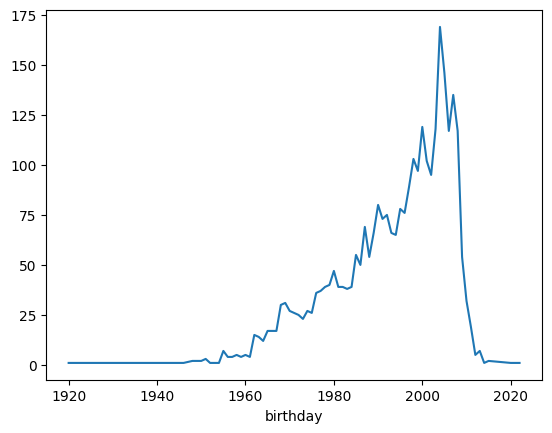

In [13]:
grouped_user['birthday'].value_counts().sort_index().plot()

In [14]:
q1_sentiment_dict = {'Goed':'Good', 'Oke':'Okay', 'Niet oke':"Not Okay" }
q2_sentiment_dict = {'Ontevreden':'AngryEm', 'Verrast':'CalmEm', 'Vreugdevol':'EnergeticEm', 'Nerveus':'AnxiousEm', 'Kalm':'CalmEm', 'Blij':'EnergeticEm',
                   'Moe':'DisengagedEm', 'Angstig':'AnxiousEm', 'Energiek':'EnergeticEm', 'Verveeld':'DisengagedEm', 'Melig':'DisengagedEm', 'Trots':'CalmEm', 'Boos':'AngryEm',
                   'Gefrustreerd':'AngryEm', 'Onverschillig':'DisengagedEm', 'Geliefd':'Positive InterpersonalEm', 'Feestelijk':'EnergeticEm',
                   'Tevreden':'CalmEm', 'Verward':'DisengagedEm', 'Geirriteerd':'AnxiousEm', 'Geinteresseerd':'CalmEm', 'Somber':'DisengagedEm',
                   'Opgelaten':'AngryEm', 'Verliefd':'Positive InterpersonalEm', 'Teleurgesteld':'AngryEm', 'Bezorgd':'AnxiousEm', 'Verdrietig':'DisengagedEm',
                   'Bewondering':'Positive InterpersonalEm'}
q3_sentiment_dict = {'Ziek':'NegativeSt', 'nan':'NeutralSt', 'Oke nacht':'NeutralSt', 'Stress':'NegativeSt', 'Sporten':'PositiveSt', 'Compliment':'PositiveSt',
                'Leuke taak':'PositiveSt', 'Slecht nieuws':'NegativeSt', 'Selfcare':'PositiveSt', 'Rust':'PositiveSt', 'Goed nieuws':'PositiveSt',
                'Goede nacht':'PositiveSt', 'Eenzaam':'NegativeSt', 'Feest':'PositiveSt', 'Iets anders':'NeutralSt', 'Matig nieuws':'NeutralSt',
                'Gesprek':'PositiveSt', 'Iemand ontmoet':'PositiveSt', 'Agenda':'NeutralSt', 'Weet ik niet':'NeutralSt', 'Vakantie':'PositiveSt',
                'Slechte nacht':'NegativeSt', 'Omgeving':'NeutralSt', 'Nieuwe relatie':'PositiveSt', 'Matige taak':'NeutralSt',
                'Volle agenda':'NeutralSt', 'Ruzie':'NegativeSt', 'Stomme taak':'NegativeSt', 'Verrassing':'NeutralSt'}
q4_sentiment_dict = {'Iets anders':'LeisureAc', 'nan':'EssentialAc', 'Werken':'OutdoorAc', 'Relaxen':'PassiveAc', 'Eten/drinken':'EssentialAc', 'Niets':'PassiveAc',
            'Huiswerk':'LeisureAc', 'Sporten':'OutdoorAc', 'Buiten zijn':'OutdoorAc', 'Gamen':'LeisureAc', 'Televisie':'PassiveAc',
            'Visite/bezoek':'EssentialAc'
        }
copy_clean_data = clean_data.copy()
copy_clean_data['question_1'] = copy_clean_data['question_1'].apply(lambda x: q1_sentiment_dict[x] if isinstance(x, str) else 'nan')
copy_clean_data['question_2'] = copy_clean_data['question_2'].apply(lambda x: q2_sentiment_dict[x] if isinstance(x, str) else 'nan')
copy_clean_data['question_3'] = copy_clean_data['question_3'].apply(lambda x: q3_sentiment_dict[x] if isinstance(x, str) else 'NeutralSt')
copy_clean_data['question_4'] = copy_clean_data['question_4'].apply(lambda x: q4_sentiment_dict[x] if isinstance(x, str) else 'EssentialAc')
copy_clean_data['question_5'] = copy_clean_data['question_5'].apply(lambda x: 'Alone' if x=='Alleen' else 'Not Alone')

* User Entry Summary

On average 19 entry per user and median value is 4

In [15]:
clean_data.groupby('user_id')['question_1'].count().describe()

count    3043.000000
mean       19.478475
std        60.975344
min         1.000000
25%         2.000000
50%         4.000000
75%        15.000000
max      1618.000000
Name: question_1, dtype: float64

Mostly people born in 2000 - 2010 are using actively. Decline is steep after 2010 and incline is not so steep after 1990.

<Axes: xlabel='birthday'>

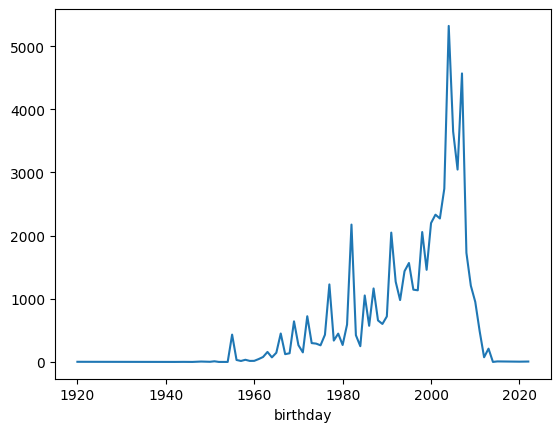

In [16]:
clean_data.groupby('birthday')['question_1'].count().plot()

* Average number of Entries per gender

In [17]:
gender_counts = clean_data.groupby(['user_id']).agg({'gender':set})['gender'].value_counts()
gender_counts.index = [list(x)[0] if x else 'Unknown' for x in gender_counts.index]

clean_data.groupby('gender')['question_1'].count()/gender_counts

he         17.753669
not_say     7.853659
she        20.380668
them       27.073171
dtype: float64

* Questions and daily step

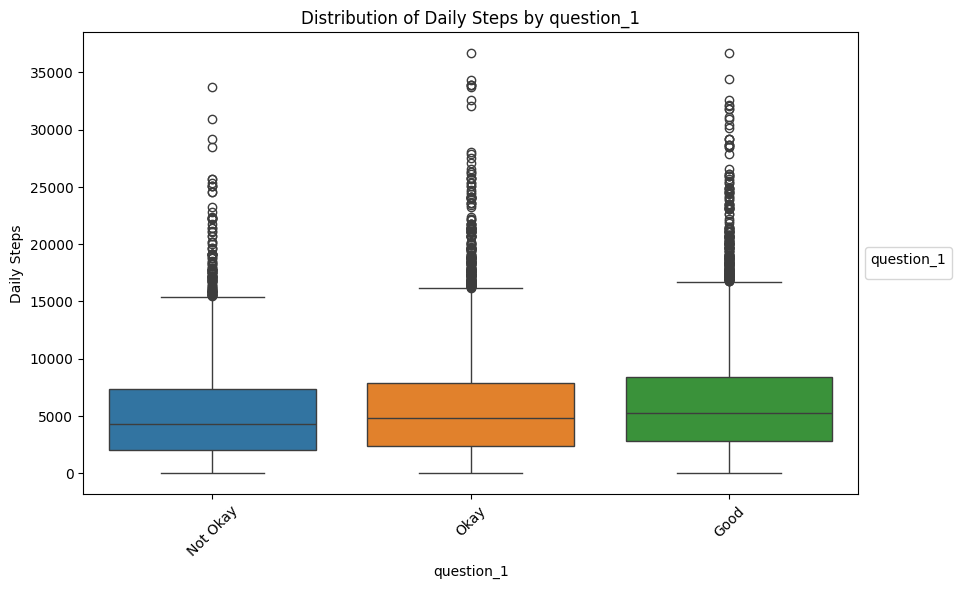

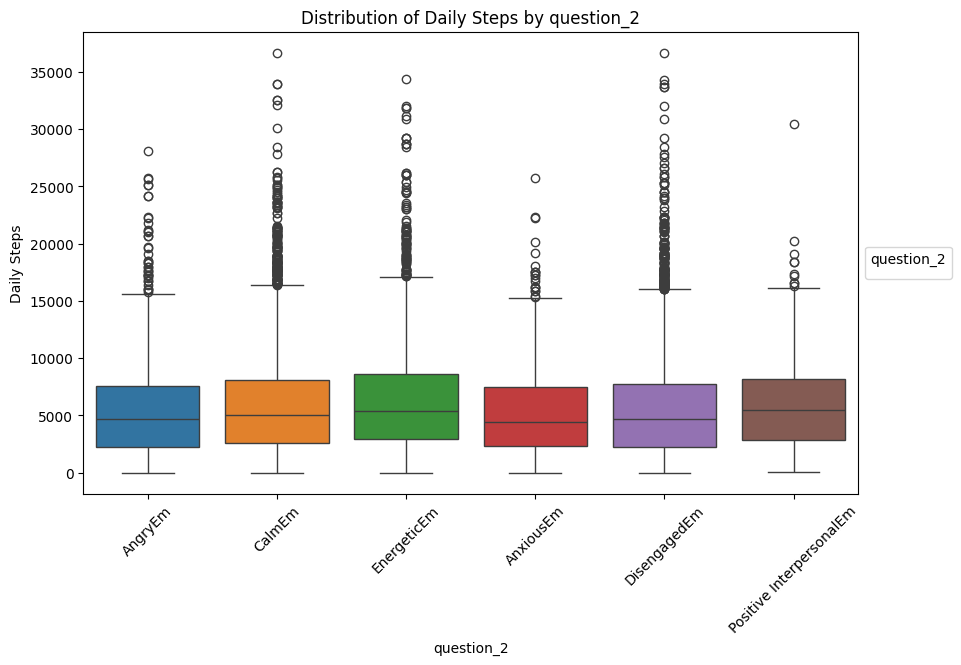

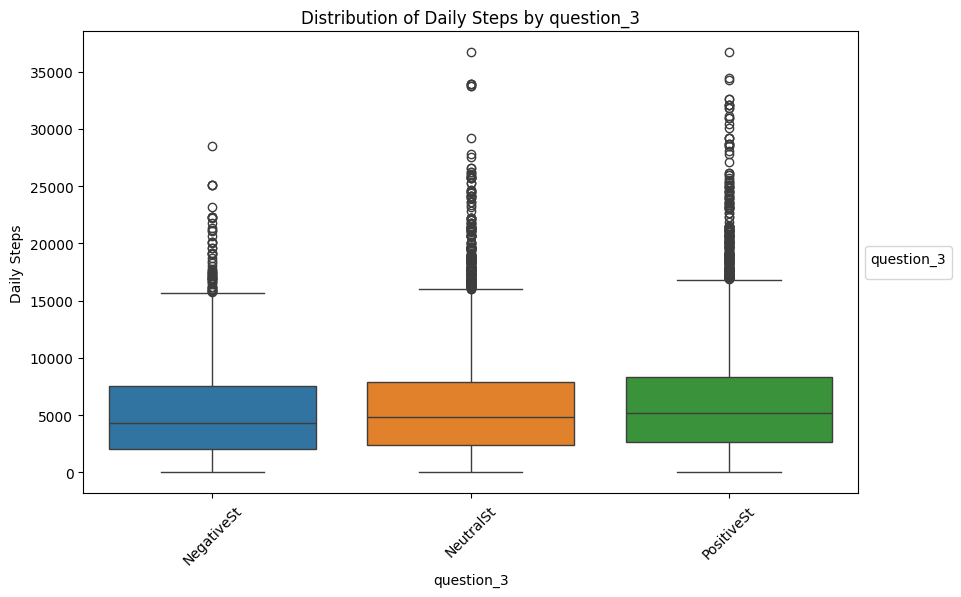

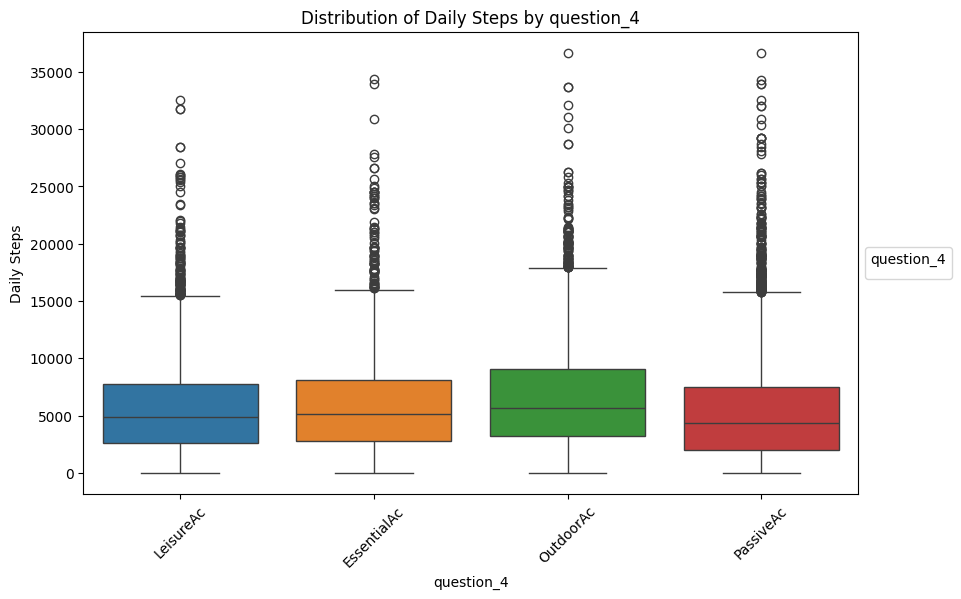

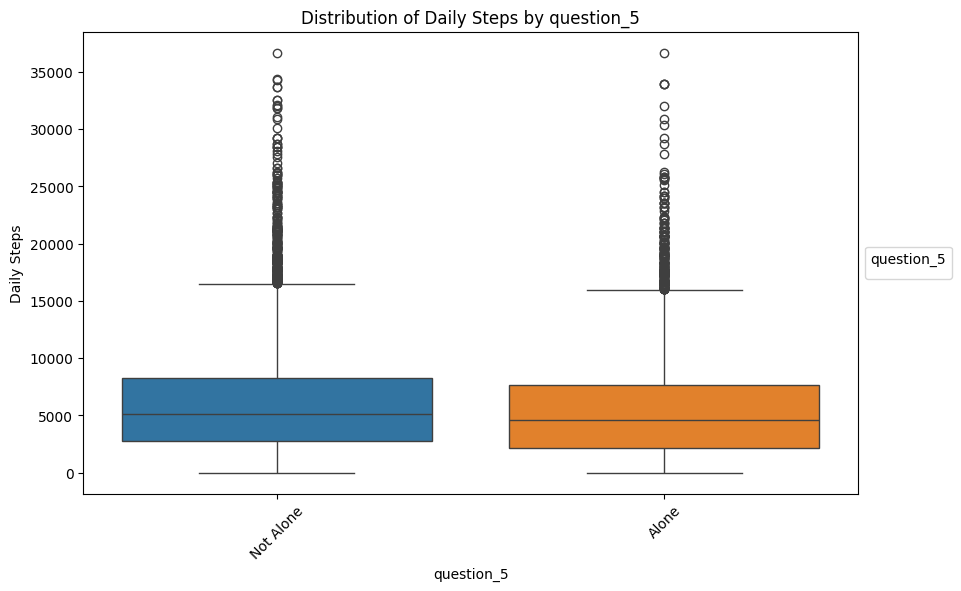

In [18]:
steps = copy_clean_data[(copy_clean_data.daily_step != -1) & (copy_clean_data.daily_step < 100_000)]
boxplot(steps, 'question_1')
boxplot(steps, 'question_2')
boxplot(steps, 'question_3')
boxplot(steps, 'question_4')
boxplot(steps, 'question_5')

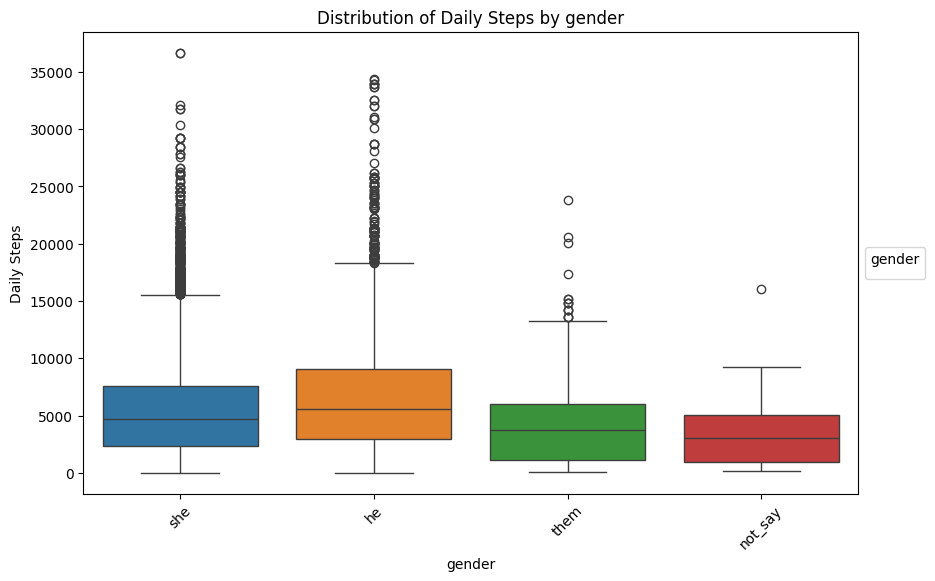

In [19]:
boxplot(steps, 'gender')

In [20]:
copy_clean_data.question_2.value_counts(normalize=True)

question_2
DisengagedEm                0.374589
CalmEm                      0.302161
EnergeticEm                 0.187404
AngryEm                     0.061073
AnxiousEm                   0.050343
Positive InterpersonalEm    0.024429
Name: proportion, dtype: float64

* Users in clustering
We are only using information from 598 individual.
50 top users are already creating the half of the data that we are using in our clustering. 550 people are the other half of the data.

In [21]:
final_data.user_id.apply(lambda x: x.split('_')[1]).value_counts()

user_id
3973    518
8400    432
9654    249
1072    201
6413    155
       ... 
8565      1
7505      1
1310      1
6870      1
6507      1
Name: count, Length: 598, dtype: int64

### STATISTICAL DATA ANALYSIS

#### SDA FUNCTIONS

In [22]:
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact
from scipy.stats import f_oneway

**Description Statistical Tests**:

1. **Chi square:**
- testing independence / testing if several groups have same data distribution.


2. **ANOVA:**
- A one-way analysis of variance (ANOVA) is used when you have a categorical independent variable (with two or more categories) and a  dependent variable and you wish to test for differences in the means of the dependent variable broken down by the levels of the independent variable.


Some inspiration from: https://stats.oarc.ucla.edu/spss/whatstat/what-statistical-analysis-should-i-usestatistical-analyses-using-spss/#:~:text=A%20one%2Dway%20analysis%20of,levels%20of%20the%20independent%20variable.


In [23]:
def chi_square(data, group, feature):
  df = pd.DataFrame(data)
  contingency_table = pd.crosstab(df[group], df[feature])

  # Perform Chi-Square test
  chi2, p, dof, expected = chi2_contingency(contingency_table)

  # Print results
  print("Chi-Square Statistic:", chi2)
  print("P-value:", p)
  print("Degrees of Freedom:", dof)
  print("Expected Frequencies:")
  print(expected)

def anova_age(data, pval):
    """
    Perform ANOVA to test for significant differences in daily steps between youth and adult groups.

    Args:
    data (DataFrame): DataFrame containing the data.

    Returns:
    None. Prints ANOVA results and interpretation.
    """
    # Extract daily steps for youth and adult groups
    young_steps = data[data['youth'] == 1]['daily_steps']
    adult_steps = data[data['youth'] == 0]['daily_steps']

    # Perform ANOVA
    f_statistic, p_value = f_oneway(young_steps, adult_steps)

    # Print ANOVA results
    print("ANOVA Results:")
    print("F-statistic:", f_statistic)
    print("P-value:", p_value)

    # Interpret results
    alpha = pval
    if p_value < alpha:
        print("There is a significant difference in daily steps between youth and adult groups.")
    else:
        print("There is no significant difference in daily steps between youth and adult groups.")

def anova_question1(data, pval):
    """
    Perform ANOVA to test for significant differences in daily steps based on the values in the 'question_1' column.

    Args:
    data (DataFrame): DataFrame containing the data.

    Returns:
    None. Prints ANOVA results and interpretation.
    """
    # Extract daily steps for each group based on the values in 'question_1'
    goed_steps = data[data['question_1'] == 'Good']['daily_steps']
    oke_steps = data[data['question_1'] == 'Okey']['daily_steps']
    niet_oke_steps = data[data['question_1'] == 'Not okey']['daily_steps']

    # Perform ANOVA
    f_statistic, p_value = f_oneway(goed_steps, oke_steps, niet_oke_steps)

    # Print ANOVA results
    print("ANOVA Results:")
    print("F-statistic:", f_statistic)
    print("P-value:", p_value)

    # Interpret results
    alpha = pval
    if p_value < alpha:
        print("There is a significant difference in daily steps based on the values in 'question_1'.")
    else:
        print("There is no significant difference in daily steps based on the values in 'question_1'.")

def anova_gender(data, pval):
    """
    Perform ANOVA to test for significant differences in daily steps based on the values in the 'gender' column.

    Args:
    data (DataFrame): DataFrame containing the data.

    Returns:
    None. Prints ANOVA results and interpretation.
    """
    # Extract daily steps for each gender group
    she_steps = data[data['gender'] == 'she']['daily_steps']
    he_steps = data[data['gender'] == 'he']['daily_steps']
    them_steps = data[data['gender'] == 'them']['daily_steps']
    not_say_steps = data[data['gender'] == 'not_say']['daily_steps']

    # Perform ANOVA
    f_statistic, p_value = f_oneway(she_steps, he_steps, them_steps, not_say_steps)

    # Print ANOVA results
    print("ANOVA Results:")
    print("F-statistic:", f_statistic)
    print("P-value:", p_value)

    # Interpret results
    alpha = pval
    if p_value < alpha:
        print("There is a significant difference in daily steps based on gender.")
    else:
        print("There is no significant difference in daily steps based on gender.")


#### SDA APPLICATION

In [24]:
data = clean_data.copy()
data.columns = ['user_id', 'gender', 'birthday', 'Date', 'Time', 'DateTime',
       'question_1', 'question_2', 'question_3', 'question_4', 'question_5',
       'response_age', 'daily_steps']
# creating a new column to differentiate between young adults and adults (24+)
data['youth'] = data['response_age'].apply(lambda x: 1 if x < 25 else 0)

# only users with steps
step_data = data[data['daily_steps'] != -1]
good_data = step_data[step_data['question_1'] == 'Goed']
okay_data = step_data[step_data['question_1'] == 'Oke']
not_okay_data = step_data[step_data['question_1'] == 'Niet oke']

# only users without steps
no_step_data = data[data['daily_steps'] == -1]
good_ws = no_step_data[no_step_data['question_1'] == 'Goed']
okay_ws = no_step_data[no_step_data['question_1'] == 'Oke']
not_okay_ws = no_step_data[no_step_data['question_1'] == 'Niet oke']

# only young adults with steps
youth_data = step_data[step_data['youth'] == 1]
# only adults (+24) with steps
adult_data = step_data[step_data['youth'] == 0]

# users by gender
she_data = step_data[step_data['gender']=='she']
he_data = step_data[step_data['gender']=='he']
them_data  =step_data[step_data['gender']=='them']
na_data = step_data[step_data['gender']=='not_say']

##### Gender-related

In [25]:
chi_square(data, 'gender', 'question_1')

Chi-Square Statistic: 58.61410130623247
P-value: 8.602794296458649e-11
Degrees of Freedom: 6
Expected Frequencies:
[[ 6989.3378098   3176.63403236  6771.02815785]
 [  132.87871375    60.39299512   128.72829113]
 [16879.72331416  7671.78593964 16352.49074621]
 [  458.0601623    208.18703288   443.75280482]]


Interpretation:

- Since the p-value (8.60e-11) is much smaller than the conventional significance level of 0.05, you reject the null hypothesis of independence.
- This means that there is a significant association between gender and the responses to "question_1".
- The expected frequencies (the last part of the output) show what would be expected if there were no association between gender and responses. The observed frequencies (not shown here) would deviate from these expected frequencies.

In summary, based on these results, you would conclude that there is a significant difference in responses to "question_1" across genders.

In [26]:
chi_square(data, 'gender', 'question_2')

Chi-Square Statistic: 779.6100243539008
P-value: 9.667439953807337e-115
Degrees of Freedom: 81
Expected Frequencies:
[[1.46873248e+02 3.65754391e+01 1.93735529e+02 1.75133489e+03
  9.25815801e+01 8.16375230e+02 1.66303950e+02 2.89746056e+02
  1.24299344e+02 2.82888162e+02 2.11166012e+02 2.77916188e+03
  1.78305265e+02 3.39465794e+03 2.29167985e+02 1.64303730e+02
  1.09154826e+03 3.47752417e+02 4.90053734e+02 1.40015353e+02
  1.92621121e+03 2.12594740e+02 4.03758558e+02 1.66018204e+02
  7.54368431e+01 3.69183338e+02 4.16902856e+02 4.40048251e+02]
 [2.79230004e+00 6.95358764e-01 3.68322845e+00 3.32957333e+01
  1.76012687e+00 1.55206249e+01 3.16170938e+00 5.50854521e+00
  2.36313330e+00 5.37816544e+00 4.01461036e+00 5.28364011e+01
  3.38987397e+00 6.45379853e+01 4.35685725e+00 3.12368195e+00
  2.07521131e+01 6.61134075e+00 9.31672094e+00 2.66192027e+00
  3.66204174e+01 4.04177281e+00 7.67610885e+00 3.15627689e+00
  1.43417745e+00 7.01877752e+00 7.92600341e+00 8.36603513e+00]
 [3.54708822e

In [27]:
chi_square(data, 'gender', 'question_3')

Chi-Square Statistic: 777.722460502478
P-value: 6.685093091215262e-113
Degrees of Freedom: 84
Expected Frequencies:
[[8.65237731e+02 9.60105276e+01 3.06605048e+02 3.12891451e+02
  1.37215046e+03 3.76041233e+02 9.47246723e+02 1.98878950e+02
  3.06147855e+03 1.05725879e+03 1.52873905e+02 5.41773691e+02
  7.02934220e+01 1.22213401e+03 4.75766454e+02 7.62083562e+02
  1.35443423e+02 1.82591450e+02 1.57160090e+02 3.12891451e+02
  5.14627858e+02 1.47444739e+02 5.91493429e+02 5.10341673e+02
  2.94317986e+01 1.36872151e+02 1.48644870e+03 3.60896715e+02
  5.52632025e+02]
 [1.64495808e+01 1.82531675e+00 5.82906214e+00 5.94857692e+00
  2.60868186e+01 7.14915729e+00 1.80087055e+01 3.78101328e+00
  5.82037015e+01 2.01002143e+01 2.90638233e+00 1.03000017e+01
  1.33639262e+00 2.32347612e+01 9.04509642e+00 1.44884517e+01
  2.57500042e+00 3.47136133e+00 2.98786969e+00 5.94857692e+00
  9.78391510e+00 2.80316502e+00 1.12452550e+01 9.70242775e+00
  5.59546505e-01 2.60216287e+00 2.82598148e+01 6.86123530e+0

In [28]:
chi_square(data, 'gender', 'question_4')

Chi-Square Statistic: 815.8483740907175
P-value: 4.039904424286009e-150
Degrees of Freedom: 33
Expected Frequencies:
[[1.10383532e+03 1.65561011e+03 3.12034215e+02 9.53533126e+02
  2.30853885e+03 1.82105682e+03 4.16302790e+03 2.68315135e+02
  9.95251987e+02 4.45763164e+02 2.27082042e+03 6.39212947e+02]
 [2.09857102e+01 3.14758490e+01 5.93227945e+00 1.81282203e+01
  4.38890895e+01 3.46212609e+01 7.91459518e+01 5.10110843e+00
  1.89213639e+01 8.47468493e+00 4.31720007e+01 1.21524809e+01]
 [2.66583692e+03 3.99841034e+03 7.53583723e+02 2.30284696e+03
  5.57527738e+03 4.39797533e+03 1.00539938e+04 6.47999190e+02
  2.40360083e+03 1.07654818e+03 5.48418484e+03 1.54374248e+03]
 [7.23420444e+01 1.08503703e+02 2.04497832e+01 6.24916910e+01
  1.51294687e+02 1.19346583e+02 2.72832318e+02 1.75845663e+01
  6.52258195e+01 2.92139760e+01 1.48822735e+02 4.18920925e+01]]


In [29]:
chi_square(data, 'gender', 'question_5')

Chi-Square Statistic: 767.9441464119847
P-value: 4.002859390685699e-140
Degrees of Freedom: 33
Expected Frequencies:
[[7.48882115e+03 1.07983269e+03 1.38500901e+03 1.77133708e+03
  5.82635315e+02 2.72601319e+02 3.51467110e+02 5.35487288e+02
  1.57160090e+03 1.17069980e+03 3.91471496e+01 6.88361193e+02]
 [1.42374707e+02 2.05293810e+01 2.63312807e+01 3.36760076e+01
  1.10768478e+01 5.18259579e+00 6.68196312e+00 1.01804869e+01
  2.98786969e+01 2.22569129e+01 7.44251177e-01 1.30868692e+01]
 [1.80860093e+04 2.60786895e+03 3.34489039e+03 4.27789881e+03
  1.40710367e+03 6.58350615e+02 8.48816831e+02 1.29323800e+03
  3.79552241e+03 2.82731915e+03 9.45430128e+01 1.66243882e+03]
 [4.90794797e+02 7.07689842e+01 9.07693216e+01 1.16088101e+02
  3.81841648e+01 1.78654699e+01 2.30340965e+01 3.50942250e+01
  1.02997992e+02 7.67241408e+01 2.56558635e+00 4.51131206e+01]]


##### Age-related

In [30]:
chi_square(data, 'youth', 'question_1')

Chi-Square Statistic: 118.76832971846578
P-value: 1.621006996022141e-26
Degrees of Freedom: 2
Expected Frequencies:
[[10695.08578948  4860.88588396 10361.02832656]
 [13764.91421052  6256.11411604 13334.97167344]]


In [31]:
chi_square(data, 'youth', 'question_2')

Chi-Square Statistic: 2335.0596492907316
P-value: 0.0
Degrees of Freedom: 27
Expected Frequencies:
[[ 224.7454659    55.96774248  296.45413595 2679.8929192   141.66834815
  1249.21750207  254.47832909  443.36945996  190.20287483  432.87550824
   323.12626322 4252.67393248  272.84274459 5194.5060989   350.67288647
   251.41759317 1670.28731463  532.13080155  749.88029963  214.25151418
  2947.48868794  325.31250316  617.83140722  254.0410811   115.43346886
   564.92440065  637.94481467  673.36190171]
 [ 289.2545341    72.03225752  381.54586405 3449.1070808   182.33165185
  1607.78249793  327.52167091  570.63054004  244.79712517  557.12449176
   415.87373678 5473.32606752  351.15725541 6685.4939011   451.32711353
   323.58240683 2149.71268537  684.86919845  965.11970037  275.74848582
  3793.51131206  418.68749684  795.16859278  326.9589189   148.56653114
   727.07559935  821.05518533  866.63809829]]


In [32]:
chi_square(data, 'youth', 'question_3')

Chi-Square Statistic: 859.234394182289
P-value: 7.391205882672146e-163
Degrees of Freedom: 28
Expected Frequencies:
[[1323.98690804  146.91532401  469.16709126  478.78654699 2099.66483897
   575.41835237 1449.47708063  304.32459973 4684.67494475 1617.81755605
   233.92767365  829.02218548  107.56300508 1870.1096452   728.01790022
  1166.14038432  207.25554637  279.40146441  240.48639347  478.78654699
   787.48362661  225.61996187  905.10333541  780.92490679   45.03654278
   209.44178631 2274.56403421  552.244209    845.63760903]
 [1704.01309196  189.08467599  603.83290874  616.21345301 2702.33516103
   740.58164763 1865.52291937  391.67540027 6029.32505525 2082.18244395
   301.07232635 1066.97781452  138.43699492 2406.8903548   936.98209978
  1500.85961568  266.74445363  359.59853559  309.51360653  616.21345301
  1013.51637339  290.38003813 1164.89666459 1005.07509321   57.96345722
   269.55821369 2927.43596579  710.755791   1088.36239097]]


In [33]:
chi_square(data, 'youth', 'question_4')

Chi-Square Statistic: 3529.6809452669986
P-value: 0.0
Degrees of Freedom: 11
Expected Frequencies:
[[1689.08897812 2533.41484318  477.47480303 1459.09653637 3532.52649604
  2786.58142831 6370.26593896  410.57586085 1522.93474263  682.10686147
  3474.80976161  978.12374943]
 [2173.91102188 3260.58515682  614.52519697 1877.90346363 4546.47350396
  3586.41857169 8198.73406104  528.42413915 1960.06525737  877.89313853
  4472.19023839 1258.87625057]]


In [34]:
chi_square(data, 'youth', 'question_5')

Chi-Square Statistic: 3862.7795150447296
P-value: 0.0
Degrees of Freedom: 11
Expected Frequencies:
[[11459.39527272  1652.36014712  2119.34099843  2710.50027837
    891.54864778   417.13458067   537.81502539   819.40272974
   2404.86393468  1791.40500734    59.90297437  1053.33040339]
 [14748.60472728  2126.63985288  2727.65900157  3488.49972163
   1147.45135222   536.86541933   692.18497461  1054.59727026
   3095.13606532  2305.59499266    77.09702563  1355.66959661]]


Conclusion: there is a significant difference in responses to every question across group ages

##### Steps-related

In [35]:
p_value = 0.05
anova_question1(step_data, p_value)

ANOVA Results:
F-statistic: nan
P-value: nan
There is no significant difference in daily steps based on the values in 'question_1'.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4133: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


In [36]:
anova_age(step_data, p_value)

ANOVA Results:
F-statistic: 1.413438547112284
P-value: 0.2344997680841111
There is no significant difference in daily steps between youth and adult groups.


In [37]:
anova_gender(step_data, p_value)

ANOVA Results:
F-statistic: 103.25198560707823
P-value: 2.3505321819189966e-66
There is a significant difference in daily steps based on gender.


#### SDA CONCLUSION



Statistical differences between groups:

- Stastistical significant differences found in:
    - Gender and Steps
    - Gender and Question1
    - Age and Question1

- NO stastistical significant differences in:
    - Age and Steps


In other words, gender affects the number of steps and the answers of the question-1 significantly. On the other hand, the age is only determinant when measuring the question-1 answers and not when measuring the steps.

### CLUSTERING

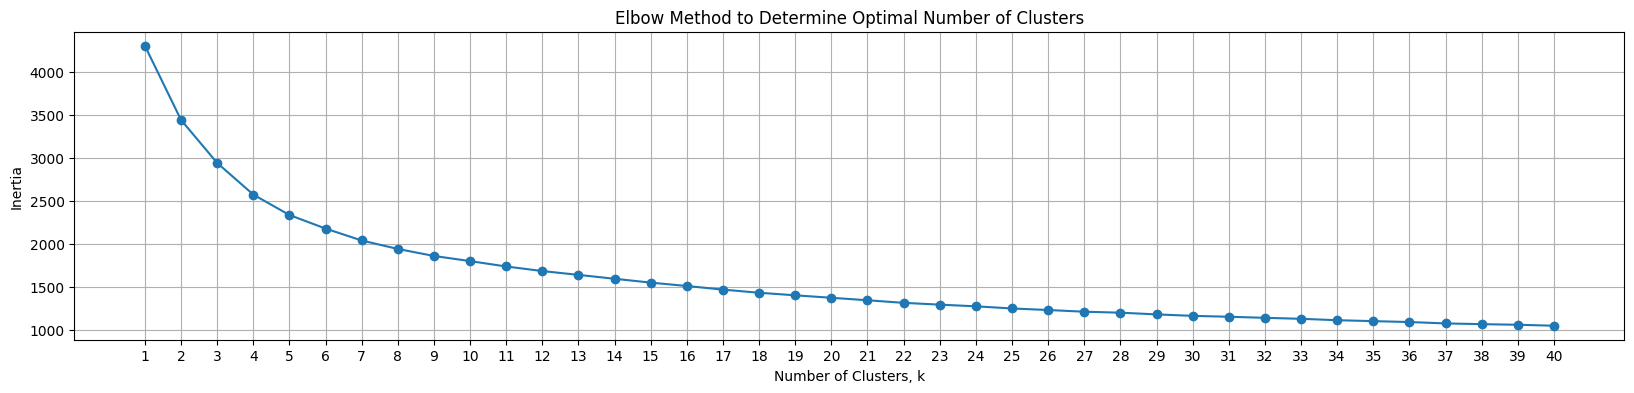

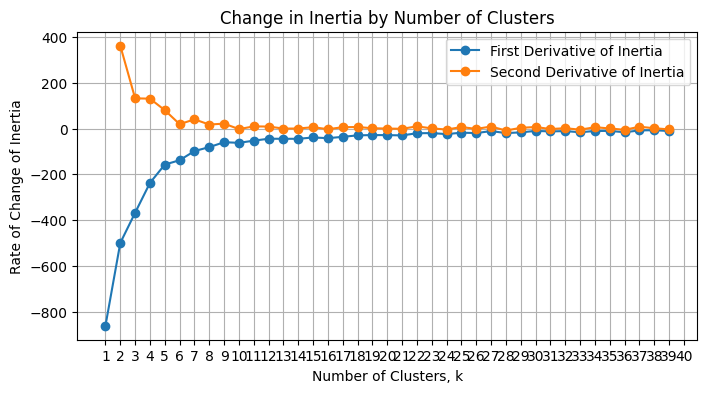

k_elbow:  8


KMeans(n_init=10, random_state=42)

In [38]:
cols = ['Q1_mean', 'Q1_std', 'Q2_mean', 'Q2_std', 'Q3_mean', 'Q3_std', 'Q4_mean', 'Q4_std', 'Q5_mean', 'Q5_std']# 'Q45_mean', 'Q45_std']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(final_data[cols])

k = cluster_number_check(scaled_data)
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans.fit(scaled_data)

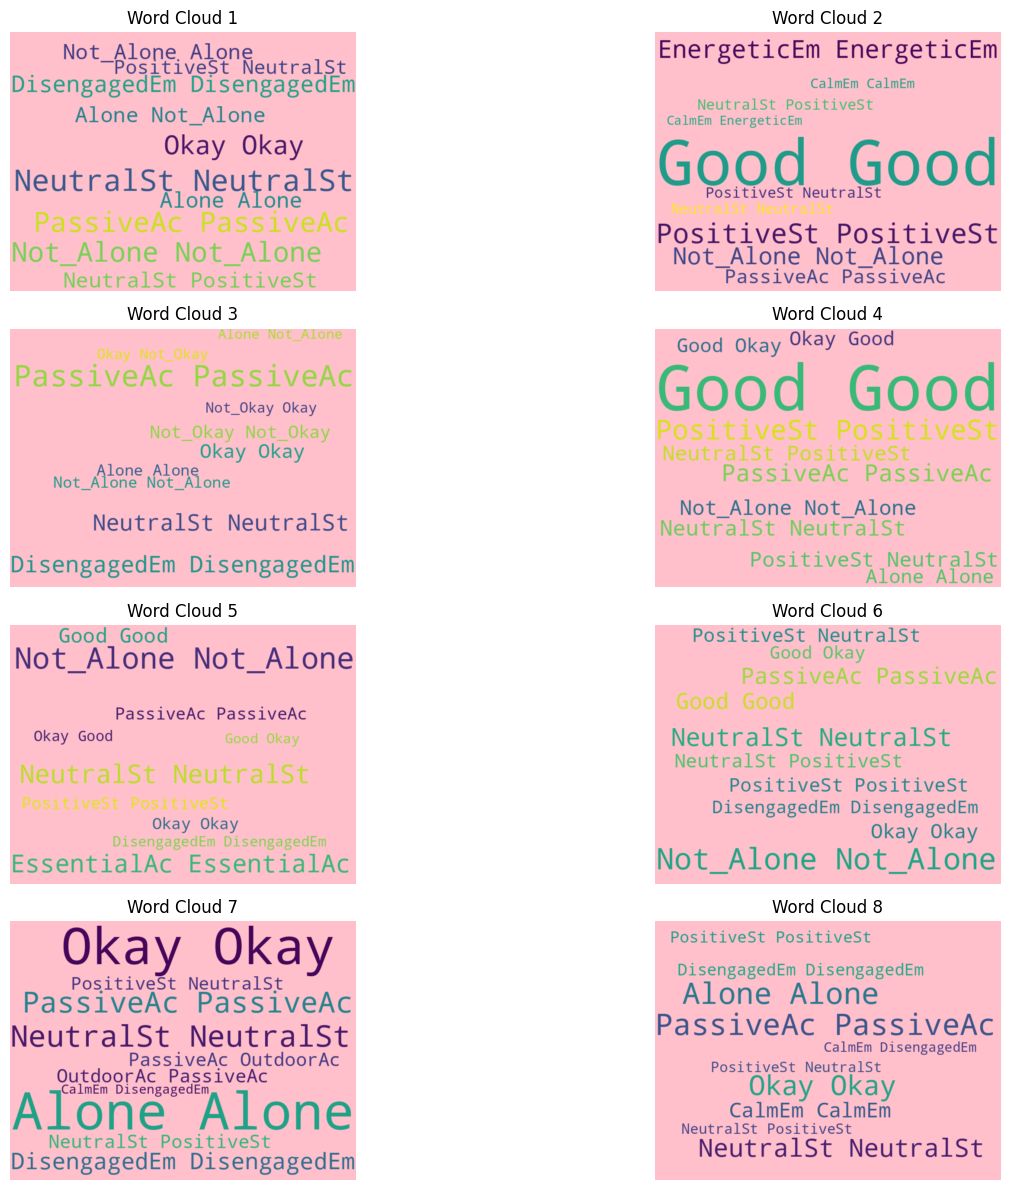

In [39]:
final_data['label'] = kmeans.labels_
final_data.label.value_counts()

trial_data = final_data.copy()
trial_data.loc[:,trial_data.columns.str.contains('question_5')] = trial_data.loc[:,trial_data.columns.str.contains('question_5')].apply(lambda x: [[z if z=='Alleen' else 'Niet_Alleen' for z in y] for y in x])
print_clouds(trial_data)

Accuracy: 0.9549376797698945
Precision: 0.955336914504267
Recall: 0.9549376797698945
F1 Score: 0.9548187563423696
   Feature  Importance
8  Q5_mean    0.242545
0  Q1_mean    0.233587
9   Q5_std    0.185756
1   Q1_std    0.106516
2  Q2_mean    0.065776
7   Q4_std    0.041696
3   Q2_std    0.034312
5   Q3_std    0.033633
6  Q4_mean    0.032390
4  Q3_mean    0.023788


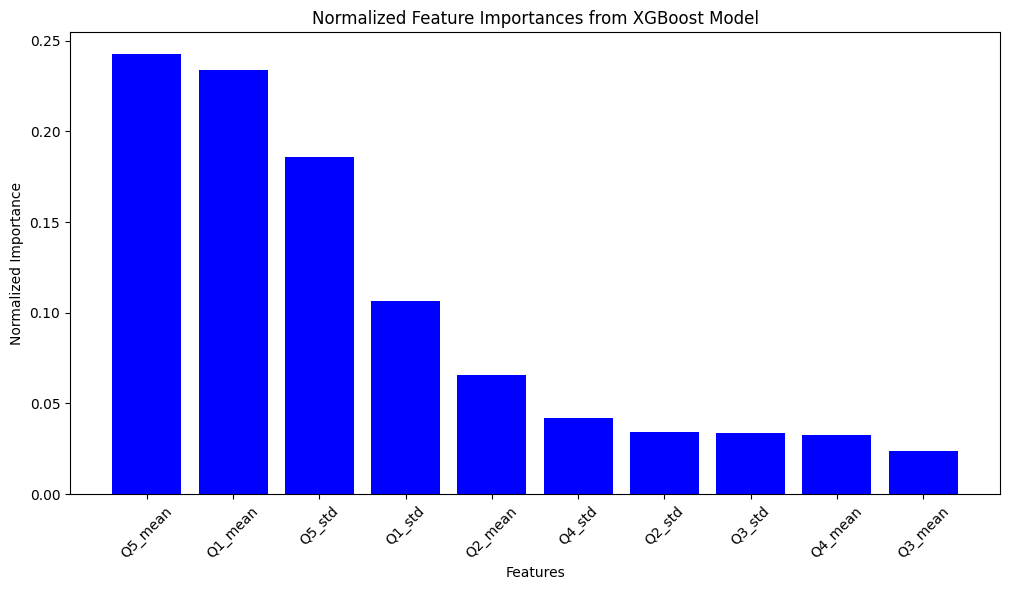

In [40]:
classification_report(final_data, cols)

In [41]:
tsne_return = tsne_application(final_data, cols, n_comp=3)

### RESULT ANALYSIS

In [42]:
trial_data.label.value_counts(normalize=False)

label
3    2343
0    2275
5    1483
6    1325
2    1157
1     786
4     568
7     485
Name: count, dtype: int64

##### GROUPED FEELINGS DISTRIBUTION

In [43]:
trial_data['F_Label'] = 1

feelings_all = trial_data.loc[:,(trial_data.columns.str.contains('QQ')|trial_data.columns.str.contains('F_Label'))].groupby('F_Label').agg(
    {
    'QQ1':list,
    'QQ2':list,
    'QQ3':list,
    'QQ4':list,
    'QQ5':list,
}
)

feelings_per_label = trial_data.loc[:,(trial_data.columns.str.contains('QQ')|trial_data.columns.str.contains('label'))].groupby('label').agg(
    {
    'QQ1':list,
    'QQ2':list,
    'QQ3':list,
    'QQ4':list,
    'QQ5':list,
}
).reset_index()


for num in range(1,6):
    question = pd.DataFrame({f'{lab}' : pd.Series([c for ccc in feelings_per_label[feelings_per_label.label == lab][f'QQ{num}'].to_list() for cc in ccc for c in cc]).value_counts(normalize = True) for lab in range(8)})
    question['all'] = pd.DataFrame({f'Question {num}' : pd.Series([c for cc in feelings_all[f'QQ{num}'][1] for c in cc]).value_counts(normalize = True)})
    display(question)

,0,1,2,3,4,5,6,7,all
Good,0.318902,0.930967,0.061215,0.647835,0.466454,0.445801,0.201387,0.182218,0.418090
Not Okay,0.268447,0.001651,0.427919,0.048868,0.169555,0.141366,0.187301,0.176715,0.176479
Okay,0.412651,0.067382,0.510867,0.303297,0.363990,0.412834,0.611312,0.641066,0.405431


,0,1,2,3,4,5,6,7,all
AngryEm,0.096744,0.003827,0.095435,0.029254,0.035845,0.053493,0.076549,0.052831,0.060265
AnxiousEm,0.072539,0.000150,0.082310,0.013028,0.046928,0.045801,0.044757,0.075578,0.045776
CalmEm,0.273512,0.253020,0.152293,0.359508,0.311284,0.309498,0.319333,0.474012,0.301414
DisengagedEm,0.403743,0.062730,0.645730,0.269566,0.334512,0.358359,0.495046,0.326159,0.370851
EnergeticEm,0.127037,0.639754,0.018492,0.292354,0.256809,0.202983,0.054148,0.069219,0.197342
Positive InterpersonalEm,0.026425,0.040519,0.005739,0.036290,0.014621,0.029867,0.010166,0.002201,0.024351


,0,1,2,3,4,5,6,7,all
NegativeSt,0.187224,0.000975,0.246825,0.028567,0.062728,0.083870,0.122598,0.095512,0.109367
NeutralSt,0.461485,0.284085,0.611616,0.417567,0.621625,0.525196,0.586586,0.590192,0.492327
PositiveSt,0.351291,0.714940,0.141559,0.553866,0.315647,0.390934,0.290816,0.314296,0.398306


,0,1,2,3,4,5,6,7,all
EssentialAc,0.158827,0.194717,0.133163,0.158921,0.427426,0.175589,0.083915,0.148954,0.163748
LeisureAc,0.226051,0.151572,0.207875,0.190378,0.137366,0.210557,0.154777,0.119848,0.189839
OutdoorAc,0.251578,0.229009,0.105479,0.232353,0.162127,0.212834,0.280391,0.087196,0.216632
PassiveAc,0.363543,0.424702,0.553483,0.418348,0.273081,0.401020,0.480917,0.644001,0.429782


,0,1,2,3,4,5,6,7,all
Alone,0.471142,0.200045,0.503427,0.483561,0.002358,0.164364,0.801542,0.959276,0.456613
Not Alone,0.528858,0.799955,0.496573,0.516439,0.997642,0.835636,0.198458,0.040724,0.543387


##### GENDER DISTRIBUTION PER LABEL

In [44]:
gender = pd.DataFrame({num:trial_data[trial_data.label==num].gender.value_counts(normalize=True) for num in range(8) })
gender['all'] = pd.DataFrame(trial_data.gender.value_counts(normalize=True))
gender

,0,1,2,3,4,5,6,7,all
gender,,,,,,,,,
he,0.338901,0.222646,0.258427,0.261630,0.221831,0.295347,0.341887,0.484536,0.298407
not_say,NaN,NaN,0.015557,0.000427,NaN,0.002023,0.003019,0.008247,0.002879
she,0.619780,0.777354,0.705272,0.693982,0.778169,0.698584,0.636226,0.501031,0.674247
them,0.041319,NaN,0.020743,0.043961,NaN,0.004046,0.018868,0.006186,0.024467


##### AGE DISTRIBUTION PER LABEL

In [45]:
age = pd.DataFrame({num:trial_data[trial_data.label==num].birthday.describe() for num in range(8) })
age['all'] = trial_data.birthday.describe()
age

,0,1,2,3,4,5,6,7,all
count,2275.000000,786.000000,1157.000000,2343.000000,568.000000,1483.000000,1325.000000,485.000000,10422.000000
mean,1996.590769,2001.311705,1998.748487,1996.544601,1996.998239,1997.166554,1989.750943,1986.232990,1995.928517
std,11.121738,9.635301,11.124951,10.568331,13.189368,11.419018,12.594711,13.183438,11.908278
min,1963.000000,1955.000000,1955.000000,1955.000000,1955.000000,1955.000000,1955.000000,1955.000000,1955.000000
25%,1991.000000,1998.000000,1991.000000,1992.000000,1985.000000,1991.000000,1982.000000,1973.000000,1989.000000
50%,2001.000000,2007.000000,2003.000000,1999.000000,2004.000000,2001.000000,1991.000000,1987.000000,2001.000000
75%,2004.000000,2007.000000,2006.000000,2004.000000,2007.000000,2005.000000,2002.000000,1997.000000,2005.000000
max,2011.000000,2011.000000,2013.000000,2011.000000,2011.000000,2011.000000,2013.000000,2009.000000,2013.000000


##### WEEKLY STEPS DISTRIBUTION PER LABEL

In [46]:
step = trial_data.loc[:,trial_data.columns.str.contains('daily_step')]
index = step[step>0].dropna().index
with_steps = trial_data.iloc[index]
step = pd.DataFrame({num:with_steps[with_steps.label == num].loc[:,with_steps.columns.str.contains('daily_step')].mean(axis=1).describe() for num in range(8)})
step['all'] = with_steps.loc[:,with_steps.columns.str.contains('daily_step')].mean(axis=1).describe()
step

,0,1,2,3,4,5,6,7,all
count,787.000000,139.000000,323.000000,651.000000,99.000000,468.000000,325.000000,88.000000,2880.000000
mean,6316.543293,5155.959918,4775.521893,5504.813693,6169.060606,5596.730159,5514.191648,6133.839286,5686.049355
std,3244.216262,2373.566123,3258.694157,2635.677531,4274.454817,2488.744534,2993.136684,5606.845784,3118.630211
min,591.000000,1825.714286,364.428571,438.000000,931.571429,1354.857143,531.857143,502.714286,364.428571
25%,4020.857143,3136.071429,2390.071429,3657.785714,3652.500000,3940.035714,3479.142857,2822.571429,3597.821429
50%,5693.714286,4750.428571,4242.000000,5182.428571,4812.142857,5092.214286,4946.285714,3795.642857,5066.000000
75%,7880.428571,6547.928571,6310.928571,7212.071429,6516.071429,6804.750000,7019.428571,7152.821429,7159.285714
max,25440.285714,11475.857143,14397.571429,14232.714286,19802.714286,15635.714286,14423.714286,21318.428571,25440.285714


##### MARKOV CHAIN

In [47]:
markov_table = {_from:{to:0 for to in range(8)} for _from in range(8)}
diff = 7
td = timedelta(days=diff)
markov_df = trial_data.copy()
markov_df['real_id'] = markov_df.user_id.apply(lambda x: x.split('_')[-1])
for _, group in markov_df.groupby('real_id'):
    group.sort_values(['d6_yyyy', 'd6_mm', 'd6_dd'], ascending=True, inplace=True)
    group['next_label'] = group['label'].shift(-diff).fillna(-1).astype(int)
    group[['year', 'month', 'day']] = group[['d6_yyyy', 'd6_mm', 'd6_dd']]
    group['time_shift'] = pd.to_datetime(group[['year', 'month', 'day']]).shift(-diff) - pd.to_datetime(group[['year', 'month', 'day']])
    for row in group.itertuples():
        if (row.time_shift == td) and (0<=row.next_label<=7):
            markov_table[row.label][row.next_label] += 1

transition_matrix = pd.DataFrame(markov_table).divide(pd.DataFrame(markov_table).sum(axis=1), axis=0)


In [48]:
transition_matrix

,0,1,2,3,4,5,6,7
0,0.483898,0.013559,0.093220,0.197458,0.006780,0.118644,0.077119,0.009322
1,0.013582,0.599321,0.001698,0.202037,0.084890,0.089983,0.001698,0.006791
2,0.191781,0.000000,0.522070,0.047184,0.009132,0.070015,0.103501,0.056317
3,0.188189,0.057480,0.020472,0.539370,0.007087,0.100787,0.077165,0.009449
4,0.037736,0.110512,0.040431,0.088949,0.458221,0.264151,0.000000,0.000000
5,0.217005,0.055838,0.065990,0.170051,0.064721,0.422589,0.003807,0.000000
6,0.133867,0.000000,0.086957,0.107551,0.002288,0.004577,0.554920,0.109840
7,0.029703,0.013201,0.102310,0.049505,0.003300,0.003300,0.280528,0.518152


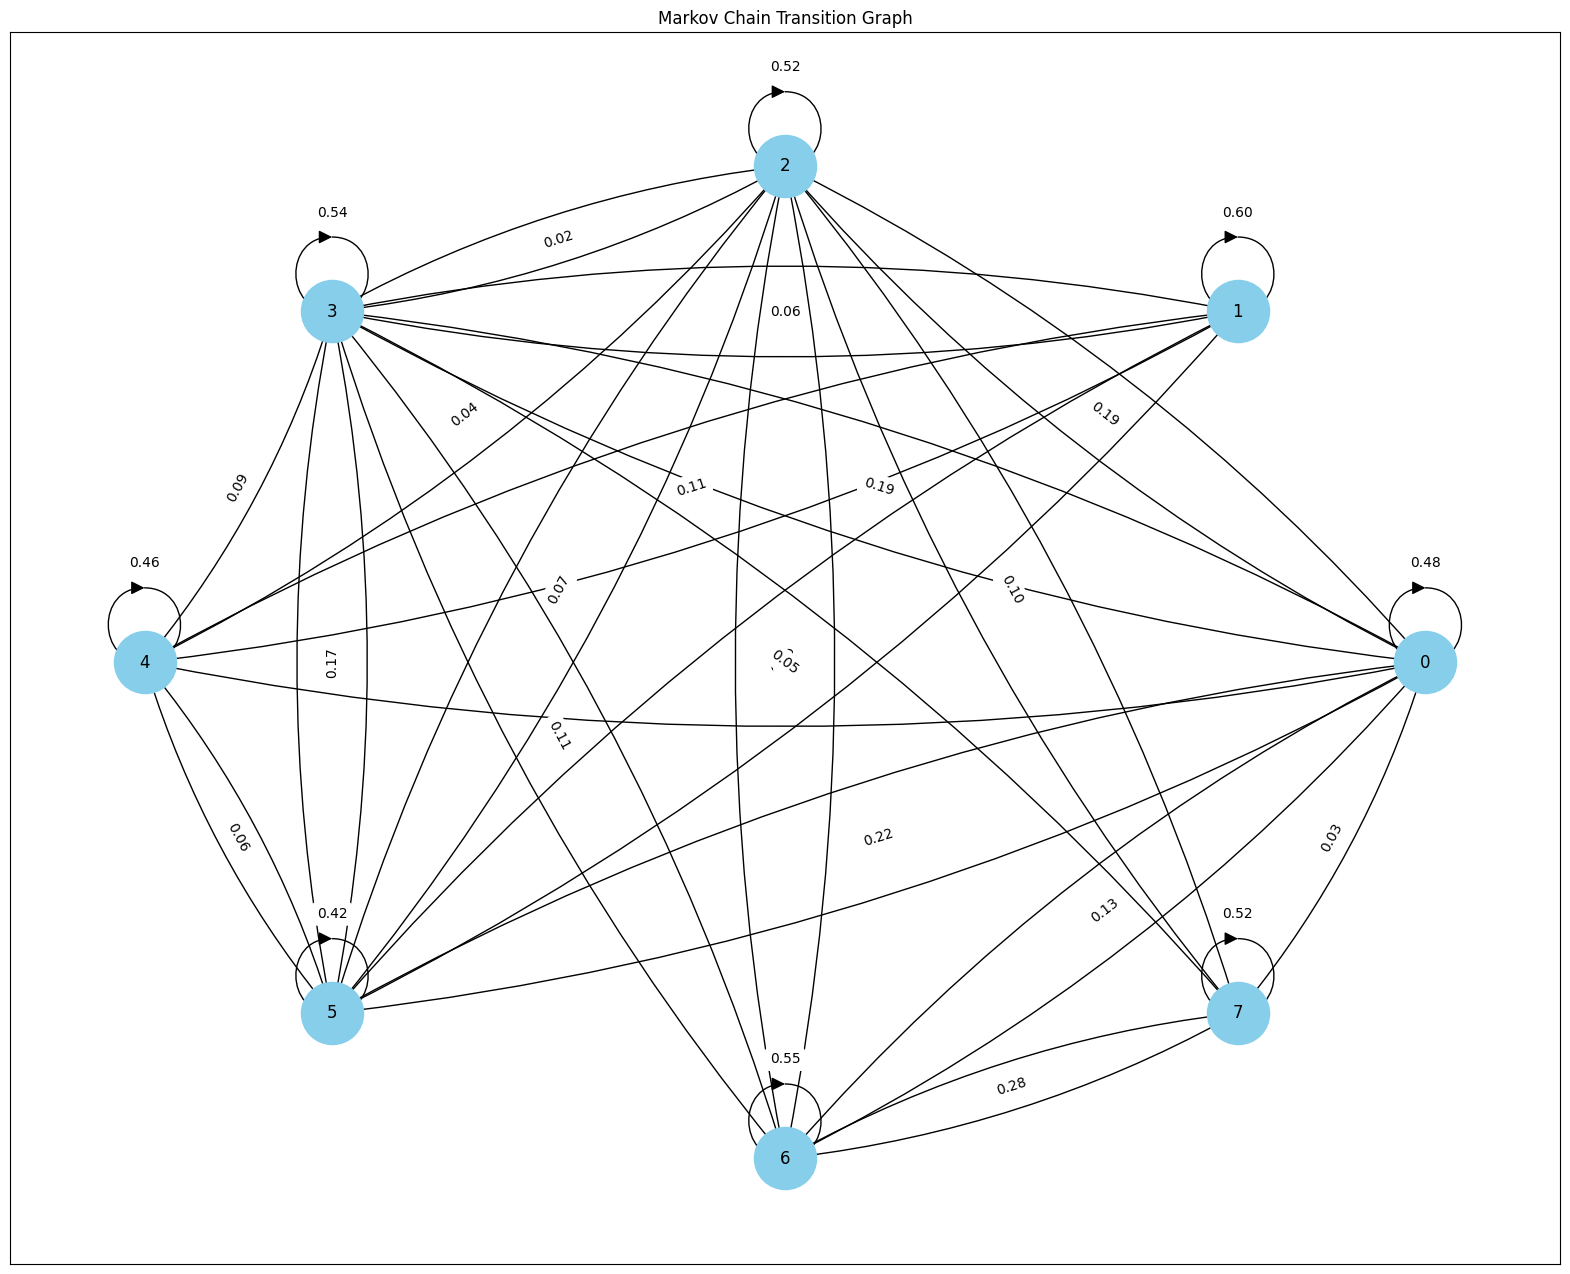

In [49]:
df = transition_matrix.copy()

# Function to adjust values
def adjust_value(x):
    if 0 < x < 0.01:
        return 0.01
    else:
        return x

# Apply the function across the DataFrame
df = df.applymap(adjust_value).round(2)

plt.figure(figsize=(20, 16))
# Create a directed graph
G = nx.DiGraph()

# Add nodes explicitly using their integer indices
for i in df.columns:
    G.add_node(i)

# Add edges (only non-zero probabilities)
for i in df.index:
    for j in df.columns:
        if df.at[i, j] > 0.01:
            G.add_edge(i, j, weight=df.at[i, j])

# Set up layout
layout = nx.circular_layout(G)

# Draw nodes
nx.draw_networkx_nodes(G, pos=layout, node_color='skyblue', node_size=2000)

# Draw edges with curved style
for edge in G.edges():
    nx.draw_networkx_edges(G, pos=layout, edgelist=[edge], connectionstyle='arc3, rad=0.1', edge_color='k',  arrows=True, arrowstyle='-|>', arrowsize=20)

# Draw labels
labels = nx.get_edge_attributes(G, 'weight')
formatted_labels = {k: f"{v:.2f}" for k, v in labels.items()}
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=formatted_labels)
nx.draw_networkx_labels(G, pos=layout)

# Show plot
plt.title('Markov Chain Transition Graph')
plt.show()


* Is the system connected?

In [50]:
df = transition_matrix.copy()

# Convert DataFrame to directed graph
G = nx.from_pandas_adjacency(df, create_using=nx.DiGraph())

# Find strongly connected components
scc = list(nx.strongly_connected_components(G))
print("Strongly connected components (potential recurrent states):", scc)

# Analyze components
recurrent_components = [comp for comp in scc if len(comp) > 1 or list(G.successors(next(iter(comp)))) == list(comp)]
print("Recurrent components:", recurrent_components)


Strongly connected components (potential recurrent states): [{0, 1, 2, 3, 4, 5, 6, 7}]
Recurrent components: [{0, 1, 2, 3, 4, 5, 6, 7}]


* Long Term Behavior of the System

In [51]:
P = df.to_numpy().T

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(P)

# Find the eigenvector corresponding to the eigenvalue 1
index = np.argmin(np.abs(eigenvalues - 1))
stationary = np.abs(eigenvectors[:, index]).real  # Take the real part and make sure it's non-negative
stationary /= stationary.sum()  # Normalize to make it a probability vector

print("Stationary distribution:", stationary)

Stationary distribution: [0.22476558 0.07032101 0.11234752 0.23198003 0.0350728  0.1287402
 0.1414983  0.05527456]
